In [1]:
import re
import os
from dotenv import load_dotenv
from collections import Counter
from operator import itemgetter
# import pypdf
# from pypdf import PdfReader
# from pdfminer.high_level import extract_text as fallback_text_extraction
from nltk.corpus import stopwords
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import giskard
from langchain import hub
from langchain.load import dumps, loads
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

load_dotenv()

/home/anggapark/miniconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [28]:
os.environ["GEMINI_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [29]:
CHROMA_PATH = "chromadb"
DOCUMENTS_PATH = "data/Shifting ML value creation mechanisms A process model of ML value creation.pdf"
MODEL = "gemini-1.5-flash"
EMBEDDING = "text-embedding-004"

giskard.llm.set_llm_model(f"gemini/{MODEL}")
giskard.llm.set_embedding_model(f"gemini/{EMBEDDING}")

# Load Document

In [30]:
def load_documents(path):
    reader = PyPDFLoader(file_path=path)
    docs = reader.load()
    
    return docs

docs = load_documents(DOCUMENTS_PATH)

# EDA

In [31]:
list_doc = [doc.page_content for doc in docs]
texts = "".join(list_doc)

In [32]:
def visualize_top_words(texts, top_n=15, color='skyblue'):
    # Lowercase the text
    texts = texts.lower()
    # Remove special characters, numbers, and punctuation
    texts = re.sub(r"[^a-z\s]", "", texts)
    
    words = texts.split()
    filtered_words = [word for word in words if word not in stopwords.words("english")]
    
    word_counts = Counter(filtered_words)
    word_counts_sw = Counter(words)

    common_words = word_counts.most_common(top_n)
    common_words_sw = word_counts_sw.most_common(top_n)

    words, counts = zip(*common_words)
    words_sw, counts_sw = zip(*common_words_sw)
    
    # Plot bar chart horizontal
    fig, axs = plt.subplots(1,2, figsize=(15, 7))
    axs[0].barh(words, counts, color=color)
    axs[0].set_xlabel('Frequency')
    axs[0].set_title(f'Top {top_n} Most Frequent Words in Documents')
    axs[0].invert_yaxis()
    
    axs[1].barh(words_sw, counts_sw, color=color)
    axs[1].set_xlabel('Frequency')
    axs[1].set_title(f'Top {top_n} Most Frequent Words in Documents (with stopwords)')
    axs[1].invert_yaxis() 
    
    plt.show()

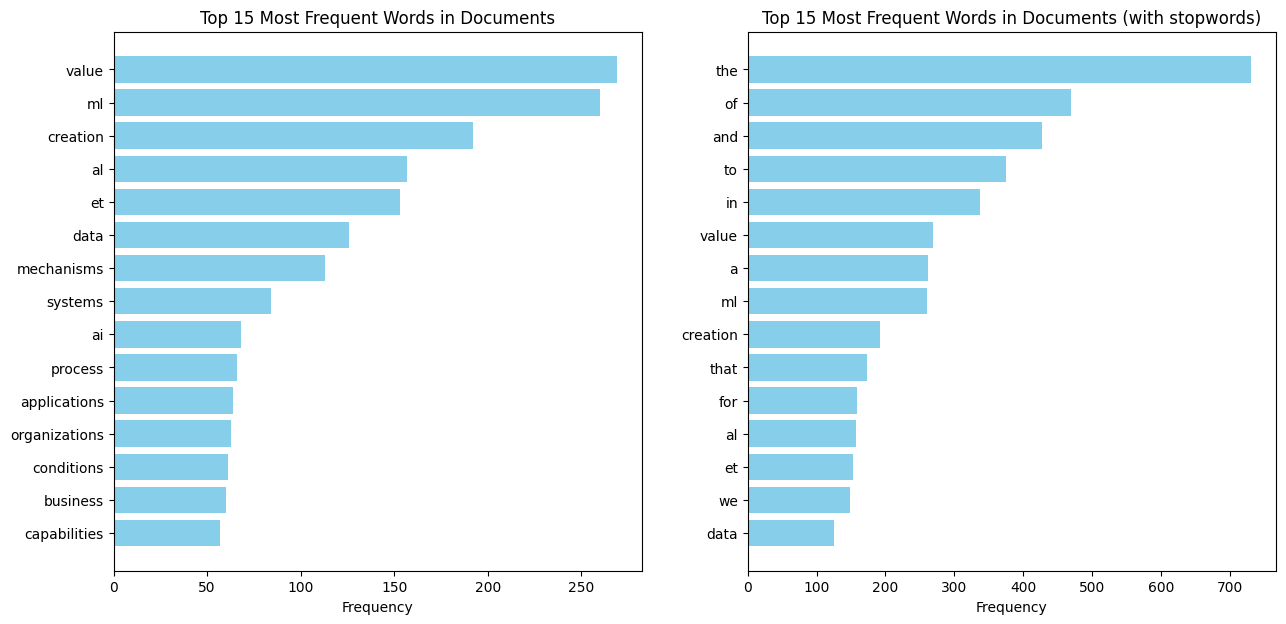

In [33]:
visualize_top_words(texts, color='skyblue')

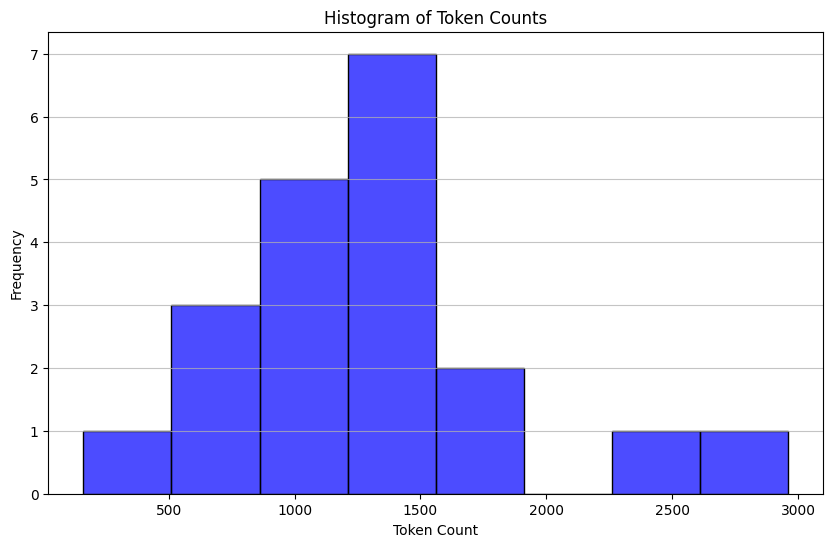

In [34]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# Calculate the number of tokens for each document
counts = [num_tokens_from_string(txt, "cl100k_base") for txt in list_doc]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
sns.histplot(counts, color="blue", edgecolor="black", alpha=0.7)
# sns.histplot(counts, kde=True, kde_kws={"cut": 3})
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show()

# Data Preprocessing

In [35]:
char_split = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200
)
docs_chunks = char_split.split_documents(docs)

In [36]:
# create db from chunks of documents
vectorstore = Chroma.from_documents(
    documents=docs_chunks, 
    embedding=GoogleGenerativeAIEmbeddings(
        model=EMBEDDING,
        ),
    persist_directory=CHROMA_PATH
    )

retriever = vectorstore.as_retriever()

# Modelling

In [37]:
# initialized llm model
llm = ChatGoogleGenerativeAI(
    model=MODEL,
    temperature=0.3,
)

## Baseline

In [12]:
template = """
You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know.

Question: {question} 

Context: {context} 

Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain_baseline = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser() # only get the answer in string format
)

In [19]:
question = "what is the impact of shifting ml value creation in machine learning development?"

rag_chain_baseline.invoke(question)

## Multiple Queries

In [38]:
# query expansion with multiple queries
# template = """
# You are an AI language model assistant. Your task is to generate five 
# different versions of the given user question to retrieve relevant documents from a vector 
# database. By generating multiple perspectives on the user question, your goal is to help
# the user overcome some of the limitations of the distance-based similarity search. 
# Provide these alternative questions separated by newlines. 
# Original question: {question}
# """
template = """
You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):
"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

In [39]:
def get_unique_union(docs: list[list]):
    # flatten list of lists and convert each docs into str 
    flattened_docs = [dumps(doc) for sublist in docs for doc in sublist]

    # get unique docs
    unique_docs = list(set(flattened_docs))
    
    return [loads(doc) for doc in unique_docs]

retrieval_chain = generate_queries | retriever.map() | get_unique_union

expanded_queries = retrieval_chain.invoke({"question": question})

In [21]:
len(expanded_queries)

5

In [40]:
template = """
Answer the following question based on this context. 

{context} 

Question: {question} 
"""
prompt = ChatPromptTemplate.from_template(template)
# prompt = hub.pull("rlm/rag-prompt")

rag_chain_multiquery = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
# question
rag_chain_multiquery.invoke({"question": question})

## RAG-Fusion

In [49]:
def reciprocal_rank_fusion(results: list[list], k=60):
    """
    Reciprocal_rank_fusion that takes multiple lists of ranked documents
    and an optional parameter k used in the RRF formula
    https://github.com/langchain-ai/langchain/blob/master/cookbook/rag_fusion.ipynb?ref=blog.langchain.dev
    """
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

In [50]:
template = """
You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):
"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

# retriever = retrieve_documents(path)

retrieval_chain = (
    prompt_perspectives
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
    | retriever.map()
    | reciprocal_rank_fusion
)

In [51]:
expanded_queries_rf = retrieval_chain.invoke({"question": question})

In [52]:
template = """
Answer the following question based on this context. 

{context} 

Question: {question} 
"""
prompt = ChatPromptTemplate.from_template(template)
# prompt = hub.pull("rlm/rag-prompt")

rag_chain_ragfusion = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
# question
rag_chain_ragfusion.invoke({"question": question})

# Evaluation

In [41]:
from giskard.rag import KnowledgeBase

df = pd.DataFrame([doc.page_content for doc in docs], columns=["docs"])
knowledge_base = KnowledgeBase(df)

## Generate Test Set

In [42]:
from giskard.rag import generate_testset
import json

# testset = generate_testset(
#     knowledge_base,
#     num_questions=10,
#     agent_description="A chatbot answering questions about machine learning research paper titled Shifting ML value creation mechanisms A process model of ML value creation"
# )
testset = giskard.rag.QATestset.load("evaluation/test-set.jsonl")

In [24]:
test_set_df = testset.to_pandas()

for index, row in enumerate(test_set_df.head(3).iterrows()):
    print("*"*110)
    print(f"Question {index + 1}: {row[1]['question']}")
    print(f"Reference answer: {row[1]['reference_answer']}")
    print("Reference context:")
    print(row[1]['reference_context'])
    print("*"*110, end="\n\n")

**************************************************************************************************************
Question 1: What are the three main value creation mechanisms identified in the study of ML applications, and what are their primary value targets?
Reference answer: The three main ML value creation mechanisms are: 1) Knowledge creation (supporting humans in discovering new knowledge by providing ML-based tools for identifying trends and patterns); 2) Task augmentation (more effective decision-making by enabling humans to make better or faster decisions); and 3) Autonomous agents (automation to increase productivity by substituting human labor or enabling new value propositions).
Reference context:
Document 10: Journal of Strategic Information Systems 31 (2022) 101734
11
makes all placement decisions autonomously, but also executes all required actions. Customers, however, do not even have to realize 
that ML is at work. A service provider that offers a media summary for compa

In [31]:
# testset.save("test-set-3.jsonl")

## Evaluating RAG Performance

### Baseline

In [27]:
from giskard.rag import evaluate

def answer_fn_baseline(question, history=None):
    return rag_chain_multiquery.invoke({"question": question})

report = evaluate(answer_fn_baseline, testset=testset, knowledge_base=knowledge_base)

In [34]:
# baseline
display(report)

Loading BokehJS ...

In [35]:
report.correctness_by_question_type()

,correctness
question_type,
complex,0.0
conversational,0.0
distracting element,0.5
double,1.0
simple,0.0
situational,0.5


In [53]:
report.get_failures()

,question,reference_answer,reference_context,conversation_history,metadata,agent_answer,correctness,correctness_reason
id,,,,,,,,
7e666fd5-82ac-44c3-96eb-1d147fada90e,What are the three main value creation mechani...,The three main ML value creation mechanisms ar...,Document 10: Journal of Strategic Information ...,[],"{'question_type': 'simple', 'seed_document_id'...","I'm sorry, but the provided text repeatedly st...",False,The agent stated that it could not answer the ...
9f600fb4-b72e-4afe-882d-5fa6ea305a14,Which journal published the article referenced...,Journal of Strategic Information Systems 31 (2...,Document 19: Journal of Strategic Information ...,[],"{'question_type': 'simple', 'seed_document_id'...","The provided text is a bibliography entry, not...",False,The agent failed to extract the journal name f...
9687c76a-d75d-444d-ad12-ee36bb8a97e0,Considering the research paper 'Shifting ML va...,The three main interrelated elements are: ML v...,Document 14: Journal of Strategic Information ...,[],"{'question_type': 'complex', 'seed_document_id...","I am sorry, but the provided text does not con...",False,The agent stated that it could not answer the ...
d409de56-23c8-44d9-844f-d2591154c472,"Based on the provided excerpts from ""Shifting ...",What are the value creation mechanisms that or...,Document 16: Journal of Strategic Information ...,[],"{'question_type': 'complex', 'seed_document_id...","Based on the provided text, the central resear...",False,The agent's answer is partially correct in ide...
f6ac9957-c8ff-4bca-863a-58ce1633a06c,Considering the provided excerpt focuses on ma...,https://doi.org/10.1016/j.jsis.2006.04.001,Document 18: Journal of Strategic Information ...,[],"{'question_type': 'distracting element', 'seed...","I cannot find the DOI for the article ""The tra...",False,The agent stated that it could not find the DO...
5e6dde4d-de3f-44eb-8ebe-a3478f143bc8,"Hi, I'm doing a literature review on machine l...",What are the value creation mechanisms that or...,Document 1: Journal of Strategic Information S...,[],"{'question_type': 'situational', 'seed_documen...",The provided text describes the methodology an...,False,The agent stated that it doesn't know the answ...
c13054a8-ce2c-4381-a3d8-bfcfce021b59,What was used to analyze that?,MAXQDA software was used to analyze all collec...,Document 6: Journal of Strategic Information S...,"[{'role': 'user', 'content': 'I'm conducting r...","{'question_type': 'conversational', 'seed_docu...",The provided text mentions that the reconfigur...,False,The agent stated that it doesn't know what sof...


In [45]:
for index, row in enumerate(report_get_failure.iterrows()):
    print("*"*110)
    print(f"Question {index + 1}: {row[1]['question']}")
    print(f"Reference answer:\n {row[1]['reference_answer']}")
    print(f"Agent answer:\n {row[1]['agent_answer']}")
    print(f"Correctness Reason:\n {row[1]['correctness_reason']}")
    print("*"*110, end="\n\n")

**************************************************************************************************************
Question 1: What are the three main value creation mechanisms identified in the study of ML applications, and what are their primary value targets?
Reference answer:
 The three main ML value creation mechanisms are: 1) Knowledge creation (supporting humans in discovering new knowledge by providing ML-based tools for identifying trends and patterns); 2) Task augmentation (more effective decision-making by enabling humans to make better or faster decisions); and 3) Autonomous agents (automation to increase productivity by substituting human labor or enabling new value propositions).
Agent answer:
 I'm sorry, but the provided text repeatedly states that a study identified three different ML value creation mechanisms (with five subtypes) but it does not name them or their value targets.  Therefore, I cannot answer your question.

Correctness Reason:
 The agent stated that it could

### Multiple Queries

In [43]:
def answer_fn_baseline(question, history=None):
    return rag_chain_multiquery.invoke({"question": question})

report = evaluate(answer_fn_baseline, testset=testset, knowledge_base=knowledge_base)

CorrectnessMetric evaluation: 100%|█████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.35s/it]


In [44]:
display(report)

Loading BokehJS ...

2024-12-09 10:06:35,350 pid:1399 MainThread giskard.rag  INFO     Finding topics in the knowledge base.


/home/anggapark/miniconda3/envs/torch/lib/python3.11/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


2024-12-09 10:06:41,102 pid:1399 MainThread giskard.rag  INFO     Found 1 topics in the knowledge base.


In [45]:
report.correctness_by_question_type()

,correctness
question_type,
complex,0.0
conversational,1.0
distracting element,1.0
double,0.0
simple,0.5
situational,1.0


In [46]:
report.get_failures()

,question,reference_answer,reference_context,conversation_history,metadata,agent_answer,correctness,correctness_reason
id,,,,,,,,
7e666fd5-82ac-44c3-96eb-1d147fada90e,What are the three main value creation mechani...,The three main ML value creation mechanisms ar...,Document 10: Journal of Strategic Information ...,[],"{'question_type': 'simple', 'seed_document_id'...","Based on the provided text, the study identifi...",False,"The agent's answer is partially correct, ident..."
9687c76a-d75d-444d-ad12-ee36bb8a97e0,Considering the research paper 'Shifting ML va...,The three main interrelated elements are: ML v...,Document 14: Journal of Strategic Information ...,[],"{'question_type': 'complex', 'seed_document_id...","Based on the provided text, the research paper...",False,The agent's response does not accurately refle...
d409de56-23c8-44d9-844f-d2591154c472,"Based on the provided excerpts from ""Shifting ...",What are the value creation mechanisms that or...,Document 16: Journal of Strategic Information ...,[],"{'question_type': 'complex', 'seed_document_id...",The central research question investigates how...,False,The agent correctly identified the methodology...
905832d2-e2bb-440a-9bf8-026068aebb39,What software was used to analyze the data fro...,MAXQDA software was used to analyze all collec...,Document 6: Journal of Strategic Information S...,[],"{'question_type': 'double', 'original_question...",MAXQDA software was used to analyze the interv...,False,The agent's response is partially correct in t...


In [48]:
report_get_failure = report.get_failures().reset_index()

for index, row in enumerate(report_get_failure.iterrows()):
    print("*"*110)
    print(f"Question {index + 1}: {row[1]['question']}")
    print(f"Reference answer:\n {row[1]['reference_answer']}")
    print(f"Agent answer:\n {row[1]['agent_answer']}")
    print(f"Correctness Reason:\n {row[1]['correctness_reason']}")
    print("*"*110, end="\n\n")

**************************************************************************************************************
Question 1: What are the three main value creation mechanisms identified in the study of ML applications, and what are their primary value targets?
Reference answer:
 The three main ML value creation mechanisms are: 1) Knowledge creation (supporting humans in discovering new knowledge by providing ML-based tools for identifying trends and patterns); 2) Task augmentation (more effective decision-making by enabling humans to make better or faster decisions); and 3) Autonomous agents (automation to increase productivity by substituting human labor or enabling new value propositions).
Agent answer:
 Based on the provided text, the study identified three main value creation mechanisms for ML applications:

1. **Knowledge Creation:**  This mechanism aims to support humans in discovering new knowledge by providing ML-based tools to identify trends and patterns in data.  Its primary v

### RAG-Fusion

In [53]:
def answer_fn_baseline(question, history=None):
    return rag_chain_ragfusion.invoke({"question": question})

report = evaluate(answer_fn_baseline, testset=testset, knowledge_base=knowledge_base)

CorrectnessMetric evaluation: 100%|█████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


In [54]:
display(report)

Loading BokehJS ...

In [55]:
report.correctness_by_question_type()

,correctness
question_type,
complex,0.0
conversational,1.0
distracting element,1.0
double,1.0
simple,0.5
situational,1.0


In [56]:
report.get_failures()

,question,reference_answer,reference_context,conversation_history,metadata,agent_answer,correctness,correctness_reason
id,,,,,,,,
7e666fd5-82ac-44c3-96eb-1d147fada90e,What are the three main value creation mechani...,The three main ML value creation mechanisms ar...,Document 10: Journal of Strategic Information ...,[],"{'question_type': 'simple', 'seed_document_id'...",The study identified three main ML value creat...,False,The agent's answer is partially correct in ide...
9687c76a-d75d-444d-ad12-ee36bb8a97e0,Considering the research paper 'Shifting ML va...,The three main interrelated elements are: ML v...,Document 14: Journal of Strategic Information ...,[],"{'question_type': 'complex', 'seed_document_id...","Based on the provided text, the paper identifi...",False,The agent's response does not accurately refle...
d409de56-23c8-44d9-844f-d2591154c472,"Based on the provided excerpts from ""Shifting ...",What are the value creation mechanisms that or...,Document 16: Journal of Strategic Information ...,[],"{'question_type': 'complex', 'seed_document_id...",The central research question investigated in ...,False,The agent's answer to the central research que...


In [57]:
report_get_failure = report.get_failures().reset_index()

for index, row in enumerate(report_get_failure.iterrows()):
    print("*"*110)
    print(f"Question {index + 1}: {row[1]['question']}")
    print(f"Reference answer:\n {row[1]['reference_answer']}")
    print(f"Agent answer:\n {row[1]['agent_answer']}")
    print(f"Correctness Reason:\n {row[1]['correctness_reason']}")
    print("*"*110, end="\n\n")

**************************************************************************************************************
Question 1: What are the three main value creation mechanisms identified in the study of ML applications, and what are their primary value targets?
Reference answer:
 The three main ML value creation mechanisms are: 1) Knowledge creation (supporting humans in discovering new knowledge by providing ML-based tools for identifying trends and patterns); 2) Task augmentation (more effective decision-making by enabling humans to make better or faster decisions); and 3) Autonomous agents (automation to increase productivity by substituting human labor or enabling new value propositions).
Agent answer:
 The study identified three main ML value creation mechanisms:

1.  **Knowledge Creation:**  This mechanism aims to support humans in discovering new knowledge by providing ML-based tools to identify trends and patterns in data.  Its primary value target is organizational knowledge crea